# This script performs an analysis of the 4 documents---.csv files in the data

## These files contain information about the content of the web page on display and the goal is to extract critical features for the webpages

In [1]:
# Importing the libraries
import os
import numpy as np
from matplotlib import pyplot as plt
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import *
%matplotlib inline

/usr/local/bin/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### 1) File Paths

In [2]:
docCat = "gs://jupyterbucket/outbrainData/documents_categories.csv"
docEnt = "gs://jupyterbucket/outbrainData/documents_entities.csv"
docMet = "gs://jupyterbucket/outbrainData/documents_meta.csv"
docTop = "gs://jupyterbucket/outbrainData/documents_topics.csv"

### 2) Function to provide a basic overview of a given file

In [7]:
def csvOverview(fpath):
    '''
    Function presents a basic overview of the file fed in the argument
    @params
    fpath: Path to the csv file that needs to be analyzed
    @returns 
    None
    '''
    # Reading the data as a spark dataframe
    print fpath.split("/")[-1]
    fpathDF = spark.read.options(header='true', inferschema='true', nullValue='\\N') \
                .csv(fpath)
    print "Dataframe has ", fpathDF.count(), " rows."
    fpathDF.show(n=5)
    fpathDF.printSchema()
    
    return None

### 3) Analyzing individual files

#### a) documents_meta.csv

In [8]:
csvOverview(docMet)

documents_meta.csv
Dataframe has  2999334  rows.
+-----------+---------+------------+--------------------+
|document_id|source_id|publisher_id|        publish_time|
+-----------+---------+------------+--------------------+
|    1595802|        1|         603|2016-06-05 00:00:...|
|    1524246|        1|         603|2016-05-26 11:00:...|
|    1617787|        1|         603|2016-05-27 00:00:...|
|    1615583|        1|         603|2016-06-07 00:00:...|
|    1615460|        1|         603|2016-06-20 00:00:...|
+-----------+---------+------------+--------------------+
only showing top 5 rows

root
 |-- document_id: integer (nullable = true)
 |-- source_id: integer (nullable = true)
 |-- publisher_id: integer (nullable = true)
 |-- publish_time: timestamp (nullable = true)



In [9]:
 docMetSchema = StructType(
                    [StructField("document_id", StringType(), True),
                     StructField("source_id", StringType(), True),
                     StructField("publisher_id", StringType(), True),
                     StructField("publish_time", StringType(), True)])
docMetDF = spark.read.schema(docMetSchema).options(header='true', inferschema='false', nullValue='\\N').csv(docMet)

In [10]:
docMetDF.orderBy(docMetDF.source_id.desc()).show(5)
print "Total distinct entries: ", docMetDF.distinct().count()
print "Total distinct documents: ", docMetDF.select('document_id').distinct().count()
print "Total distinct sources: ", docMetDF.select('source_id').distinct().count()
print "Total null values in source_id: ", docMetDF.where(docMetDF.source_id.isNull()).count()
print "Total distinct publishers: ", docMetDF.select('publisher_id').distinct().count()
print "Total null values in publisher_id: ", docMetDF.where(docMetDF.publisher_id.isNull()).count()

+-----------+---------+------------+-------------------+
|document_id|source_id|publisher_id|       publish_time|
+-----------+---------+------------+-------------------+
|    1171192|     9999|         155|2016-03-21 00:00:00|
|    1385087|     9998|        1196|               null|
|    1055593|     9998|        1196|               null|
|    1330887|     9997|        null|2015-08-14 00:00:00|
|    1266959|     9997|        null|2016-04-05 07:00:00|
+-----------+---------+------------+-------------------+
only showing top 5 rows

Total distinct entries:  2999334
Total distinct documents:  2999334
Total distinct sources:  14395
Total null values in source_id:  2518
Total distinct publishers:  1260
Total null values in publisher_id:  64024


#### We observe a lot of null entries in the dataframe and we will have to figure out some way to deal these. Lets see if the documents are uniformly distributed across sources and publishers

In [17]:
docMetDFGrpBy = docMetDF.groupBy('publisher_id', 'source_id').count().sort('count', ascending=False)
docMetDFGrpBy.show(20)
#docMetcountList = docMetDFGrpBy.select("count").rdd.map(lambda r: r(0)).collect()

+------------+---------+------+
|publisher_id|source_id| count|
+------------+---------+------+
|         925|      722|235463|
|         450|      948|211671|
|         328|     3670| 41516|
|         421|     3669| 30631|
|          27|     3962| 23941|
|         743|      417| 22432|
|        1217|    12649| 20718|
|         876|     5326| 20226|
|         151|     3307| 17222|
|         284|     1907| 16956|
|         740|        3| 16709|
|         253|      822| 16166|
|         784|     6698| 15585|
|         937|      475| 15530|
|        1119|     4789| 14201|
|        1025|     1032| 13822|
|        1089|    10030| 13223|
|         603|        1| 12867|
|         607|      481| 12491|
|          74|     1516| 12412|
+------------+---------+------+
only showing top 20 rows



#### b) document_categories.csv

In [18]:
csvOverview(docCat)

documents_categories.csv
Dataframe has  5481475  rows.
+-----------+-----------+----------------+
|document_id|category_id|confidence_level|
+-----------+-----------+----------------+
|    1595802|       1611|            0.92|
|    1595802|       1610|            0.07|
|    1524246|       1807|            0.92|
|    1524246|       1608|            0.07|
|    1617787|       1807|            0.92|
+-----------+-----------+----------------+
only showing top 5 rows

root
 |-- document_id: integer (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- confidence_level: double (nullable = true)



In [19]:
docCatSchema = StructType(
                    [StructField("document_id", StringType(), True),
                     StructField("category_id", StringType(), True),
                     StructField("confidence_level", DoubleType(), True)])

docCatDF = spark.read.schema(docCatSchema).options(header='true', inferschema='false', nullValue='\\N').csv(docCat)
docCatDF.cache()
print "Number of distinct categories: ", docCatDF.select('category_id').distinct().count()
print "Number of null values in category_id: ", docCatDF.where(docCatDF.category_id.isNull()).count()
print "Number of null values in confidence_level: ", docCatDF.where(docCatDF.confidence_level.isNull()).count()

Number of distinct categories:  97
Number of null values in category_id:  0
Number of null values in confidence_level:  0


#### Lets perform a principal component analysis on the document categories
* The categories Id are converted into a label encoding. Each category will become a column and the confidence level its correspoding value

In [20]:
# Converting the doctCatDF into a new streched out dataframe by pivoting about the category_id
docCatPivotDF = docCatDF.groupBy("document_id").pivot("category_id").agg(F.first("confidence_level")).na.fill(0)

# Combining all the 97 category dimensions to form a single vector
colCatAssembler = VectorAssembler(inputCols=docCatPivotDF.columns[1:], outputCol="allCat")
docCatPivotConcDF = colCatAssembler.transform(docCatPivotDF).select("document_id", "allCat")
docCatPivotConcDF.cache()
docCatPivotConcDF.show(truncate=False, n=5)

+-----------+--------------------------------------+
|document_id|allCat                                |
+-----------+--------------------------------------+
|2266361    |(97,[78,81],[0.041319873,0.543061188])|
|1535236    |(97,[11,44],[0.92,0.07])              |
|1112780    |(97,[36,93],[0.07,0.92])              |
|2475447    |(97,[58,62],[0.92,0.07])              |
|995816     |(97,[58,81],[0.058751826,0.772166856])|
+-----------+--------------------------------------+
only showing top 5 rows



#### At this stage we can uncache the docCatDF as we will not be needing it in the original form

In [21]:
docCatDF.unpersist()

DataFrame[document_id: string, category_id: string, confidence_level: double]

#### PCA analysis

In [22]:
catPCAextracted = PCA(k=97, inputCol = "allCat", outputCol="pca_features")
catPCAmodel = catPCAextracted.fit(docCatPivotConcDF)
catPCAExpVar = catPCAmodel.explainedVariance
catPCAExpVarCumSum = np.cumsum(catPCAExpVar)

#### Plotting the variance and cumulative variance of the data explained by principal components

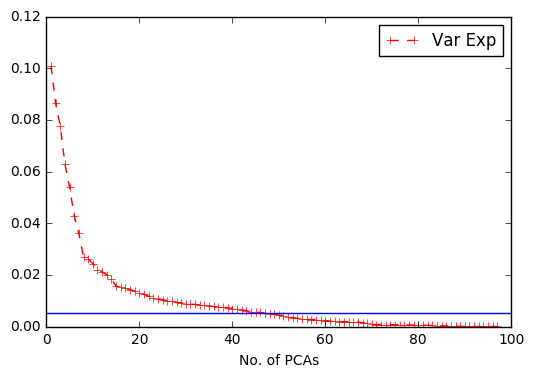

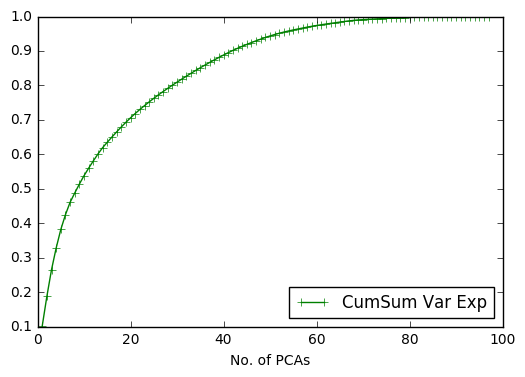

In [23]:
plt.plot(range(1, len(catPCAExpVar)+1), catPCAExpVar, 'r+--', label="Var Exp")
plt.axhline(.05*catPCAExpVar[0])
plt.xlabel("No. of PCAs")
plt.legend(loc="best")
plt.show()
plt.plot(range(1, len(catPCAExpVarCumSum)+1), catPCAExpVarCumSum, 'g+-', label="CumSum Var Exp")
plt.xlabel("No. of PCAs")
plt.legend(loc="best")
plt.show()

#### c) document_topics.csv

In [24]:
csvOverview(docTop)

documents_topics.csv
Dataframe has  11325960  rows.
+-----------+--------+------------------+
|document_id|topic_id|  confidence_level|
+-----------+--------+------------------+
|    1595802|     140|0.0731131601068925|
|    1595802|      16|0.0594164867373976|
|    1595802|     143|0.0454207537554526|
|    1595802|     170|0.0388674285182961|
|    1524246|     113| 0.196450402209685|
+-----------+--------+------------------+
only showing top 5 rows

root
 |-- document_id: integer (nullable = true)
 |-- topic_id: integer (nullable = true)
 |-- confidence_level: double (nullable = true)



In [25]:
docTopSchema = StructType(
                    [StructField("document_id", StringType(), True),
                     StructField("topic_id", StringType(), True),
                     StructField("confidence_level", DoubleType(), True)])

docTopDF = spark.read.schema(docTopSchema).options(header='true', inferschema='false', nullValue='\\N').csv(docTop)
docTopDF.cache()
print "Number of distinct topics: ", docTopDF.select('topic_id').distinct().count()
print "Number of null values in topic_id: ", docTopDF.where(docTopDF.topic_id.isNull()).count()
print "Number of null values in confidence_level: ", docTopDF.where(docTopDF.confidence_level.isNull()).count()

Number of distinct topics:  300
Number of null values in topic_id:  0
Number of null values in confidence_level:  0


#### One Hot kind of encoding

In [27]:
# Converting the docTopDF into a new streched out dataframe by pivoting about the topic_id
docTopPivotDF = docTopDF.groupBy("document_id").pivot("topic_id").agg(F.first("confidence_level")).na.fill(0)
colTopAssembler = VectorAssembler(inputCols=docTopPivotDF.columns[1:], outputCol="allTop")
docTopPivotConcDF = colTopAssembler.transform(docTopPivotDF).select("document_id", "allTop")
docTopPivotConcDF.cache()
docTopPivotConcDF.show(n=5, truncate=False)
docTopDF.unpersist()

+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|document_id|allTop                                                                                                                                                                                                                                                                                     |
+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1453211    |(300,[23,92,95,114,149,179,226,285],[0.0117641865936831,0.0237438615694819,0.0632274448012765

DataFrame[document_id: string, topic_id: string, confidence_level: double]

#### PCA analysis

In [28]:
topPCAextracted = PCA(k=300, inputCol = "allTop", outputCol="pca_features")
topPCAmodel = topPCAextracted.fit(docTopPivotConcDF)
topPCAExpVar = topPCAmodel.explainedVariance
topPCAExpVarCumSum = np.cumsum(topPCAExpVar)

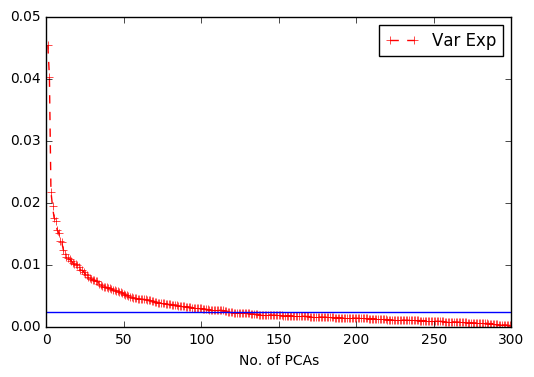

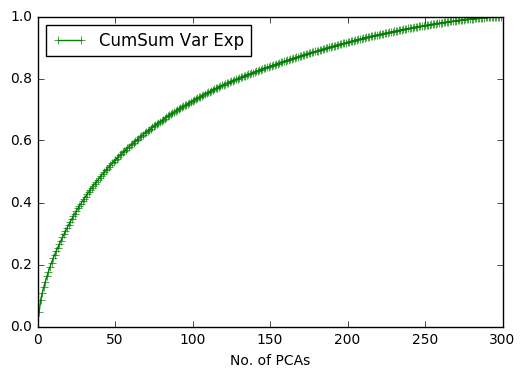

In [29]:
plt.plot(range(1, len(topPCAExpVar)+1), topPCAExpVar, 'r+--', label="Var Exp")
plt.axhline(0.05*topPCAExpVar[0])
plt.xlabel("No. of PCAs")
plt.legend(loc="best")
plt.show()
plt.plot(range(1, len(topPCAExpVarCumSum)+1), topPCAExpVarCumSum, 'g+-', label="CumSum Var Exp")
plt.legend(loc="best")
plt.xlabel("No. of PCAs")
plt.show()

#### On looking at the two sets of plots that we have made so far, we can see that we need about 45 PCAs for document category and about 200 PCAs for document topic to explain ~ 90% of the total variance in the data. So overall it seems that we dont observe any distinct advantage by performing PCA. However, may be if we merge the two datasets on document id, we might see some added features since both topic and category somewhat refer to similar domain

### Merging docTopPivotConcDF and docCatPivotConcDF

In [30]:
docTopCatDF = docTopPivotConcDF.join(docCatPivotConcDF, on="document_id", how="inner")
docTopCatDF.cache()
docTopPivotConcDF.unpersist()
docCatPivotConcDF.unpersist()
docTopCatDF.show()
colTopCatAssembler = VectorAssembler(inputCols=["allTop", "allCat"], outputCol="allTopCat")
docTopCatConcDF = colTopCatAssembler.transform(docTopCatDF).select("document_id", "allTopCat")
docTopCatConcDF.cache()
docTopCatConcDF.show()

+-----------+--------------------+--------------------+
|document_id|              allTop|              allCat|
+-----------+--------------------+--------------------+
|     100010|(300,[68,83,104,1...|(97,[39,74],[0.79...|
|    1000240|(300,[44,50,106,1...|(97,[30,32],[0.07...|
|    1000280|(300,[94,111,152,...|(97,[83,86],[0.92...|
|    1000665|(300,[94,229],[0....|(97,[22,78],[0.02...|
|    1000795|(300,[94,229],[0....|(97,[22,78],[0.02...|
|    1000839|(300,[49,90,94,95...|(97,[22,78],[0.05...|
|    1000888|(300,[50,261,273]...|(97,[92,95],[0.92...|
|     100140|(300,[16,92,157],...|(97,[39,40],[0.61...|
|    1001866|(300,[36,55,117,1...|(97,[58,62],[0.07...|
|    1002011|(300,[23,32,43,52...|(97,[64,81],[0.04...|
|    1002185|(300,[92,173,269]...|(97,[39,74],[0.04...|
|     100227|(300,[92,157,168,...|(97,[39,74],[0.05...|
|    1002442|(300,[131,156,171...|(97,[62,64],[0.92...|
|     100263|(300,[61,83,92,26...|(97,[39,45],[0.54...|
|    1002783|(300,[95,229],[0....|(97,[22,81],[0

### Now we perform PCA on the merged dataset

In [31]:
topcatPCAextracted = PCA(k=397, inputCol = "allTopCat", outputCol="topcat_pca_features")
topcatPCAmodel = topcatPCAextracted.fit(docTopCatConcDF)
topcatPCAExpVar = topcatPCAmodel.explainedVariance
topcatPCAExpVarCumSum = np.cumsum(topcatPCAExpVar)

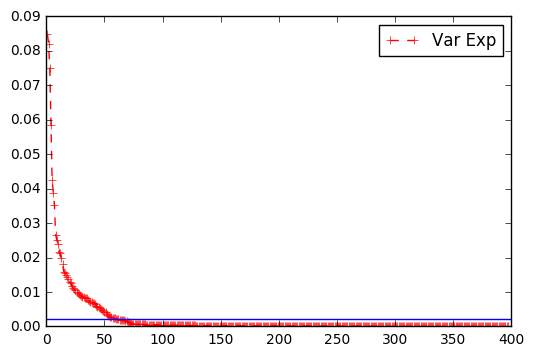

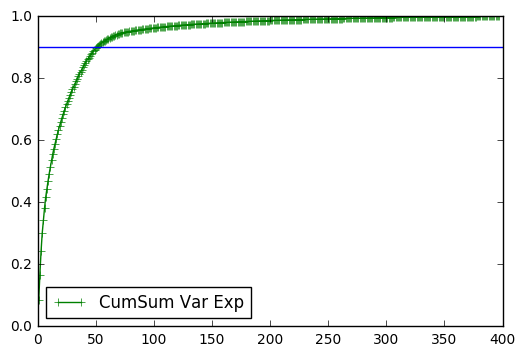

In [32]:
plt.plot(range(1, len(topcatPCAExpVar)+1), topcatPCAExpVar, 'r+--', label="Var Exp")
plt.axhline(0.05*topPCAExpVar[0])
plt.legend(loc="best")
plt.show()
plt.plot(range(1, len(topcatPCAExpVarCumSum)+1), topcatPCAExpVarCumSum, 'g+-', label="CumSum Var Exp")
plt.axhline(0.9)
plt.legend(loc="best")
plt.ylim(0, 1)
plt.show()

#### We observe that 50 PCAs from a total of 397 variables are able to explain over 90% variance in the data

#### d) document_entities.csv

In [33]:
csvOverview(docEnt)

documents_entities.csv
Dataframe has  5537552  rows.
+-----------+--------------------+-----------------+
|document_id|           entity_id| confidence_level|
+-----------+--------------------+-----------------+
|    1524246|f9eec25663db4cd83...|0.672865314504701|
|    1524246|55ebcfbdaff1d6f60...|0.399113728441297|
|    1524246|839907a972930b17b...|0.392095749652966|
|    1524246|04d8f9a1ad48f126d...|0.213996376305138|
|    1617787|612a1d17685a498af...|0.386192829940441|
+-----------+--------------------+-----------------+
only showing top 5 rows

root
 |-- document_id: integer (nullable = true)
 |-- entity_id: string (nullable = true)
 |-- confidence_level: double (nullable = true)



In [34]:
docEntSchema = StructType(
                    [StructField("document_id", StringType(), True),
                     StructField("entity_id", StringType(), True),
                     StructField("confidence_level", DoubleType(), True)])

docEntDF = spark.read.schema(docEntSchema).options(header='true', inferschema='false', nullValue='\\N').csv(docEnt)
docEntDF.cache()
print "Number of entities entries: ", docEntDF.select('entity_id').count()
print "Number of distinct entities: ", docEntDF.select('entity_id').distinct().count()
print "Number of null values in entity_id: ", docEntDF.where(docEntDF.entity_id.isNull()).count()
print "Number of null values in confidence_level: ", docEntDF.where(docEntDF.confidence_level.isNull()).count()
docEntDF.show(n=10)

Number of entities entries:  5537552
Number of distinct entities:  1326009
Number of null values in entity_id:  0
Number of null values in confidence_level:  0
+-----------+--------------------+-----------------+
|document_id|           entity_id| confidence_level|
+-----------+--------------------+-----------------+
|    1524246|f9eec25663db4cd83...|0.672865314504701|
|    1524246|55ebcfbdaff1d6f60...|0.399113728441297|
|    1524246|839907a972930b17b...|0.392095749652966|
|    1524246|04d8f9a1ad48f126d...|0.213996376305138|
|    1617787|612a1d17685a498af...|0.386192829940441|
|    1617787|fb8c6cb0879e0de87...|0.364116465983032|
|    1617787|793c6a6cf386edb82...|0.349168245516694|
|    1617787|b525b84d5ed52a345...|0.287004519610819|
|    1617787|758cb9cb3014607cb...|0.237956988738312|
|    1617787|d523aaba6d3916f8b...|0.235798527030791|
+-----------+--------------------+-----------------+
only showing top 10 rows



#### As we see there are 1,326,009 total distinct entities and therefore the pivot function that helped us perform the one hot kind of encoding is giving some issues. There is a pivatMaxValues cutoff that is set to 10,000 and has to be changed manually in order to proceed and I haven't been able to find the variable and change it. So I am attempting to perform the same operation manually

In [40]:
def getConfArray(entityList, tup2conv):
    '''
    Function converts the tup2conv into a one hot encoding using the refList
    @params
    entityList: a python list with names of all the entity_ids
    tup2conv: list of tuple kind of object containing pair of (entity_id, confidence_level)
    @returns
    A sparse vector
    '''    
    entityIdx = []
    confLevVal = []
    for tupPair in tup2conv:
        entityIdx.append(entityList.index(tupPair[0]))
        confLevVal.append(tupPair[1])

    return Vectors.sparse(len(entityList), entityIdx, confLevVal)

def performPivot(dfname, groupByCol, pivotCol, values):
    '''
    This function performs a pivoting job similar to the ones performed above using pysparks pivot function.
    @params
    dfname: dataframe that needs to used to create a new df
    pivotCol: column name around which it needs to be pivoted
    values: column to be used for assigning values to the new variable
    @returns
    pyspark dataframe
    '''
    # Variable to define an output type for a userDefinedFunction udf
    mergedSchema = ArrayType(StructType([
                StructField(pivotCol, StringType(), True),
                StructField(values, DoubleType(), True)]))
    
    # An array to be used for comparison while creating a sparse confidence_level vector for each document_id
    entityArray = dfname.select("entity_id").distinct().rdd.map(lambda r: r(0)).collect()
    
    # User Defined Functions
    createTup = F.udf(lambda entID, conLev: [(entID[i], conLev[i]) for i in range(len(entID))], mergedSchema)
    #createPivotedData = F.udf(lambda tupleVec: getConfArray(entityArray, tupleVec), ArrayType(FloatType(), containsNull=False))
    
    groupedDF = dfname.groupBy(groupByCol).agg(F.collect_list(pivotCol).alias(pivotCol+'s'), F.collect_list(values).alias(values+'s'))
    groupedTupDF = groupedDF.select('document_id', createTup(groupedDF.entity_ids, groupedDF.confidence_levels).alias("entityID_confLev"))
    
    groupedTupDF.show()
    return None

performPivot(docEntDF, "document_id", "entity_id", "confidence_level")

+-----------+--------------------+
|document_id|    entityID_confLev|
+-----------+--------------------+
|     100010|[[e02abf90d2468f5...|
|    1000280|[[0de673b866f813d...|
|    1000665|[[2b52dff4d22372a...|
|    1000795|[[0118cc1dfcd36e7...|
|    1000839|[[ad7ba80ab1cdfed...|
|    1000888|[[a40341963e70ad4...|
|    1001866|[[f99562839169726...|
|    1002011|[[2682af480e68d7d...|
|    1002442|[[7abd44c1c64174b...|
|     100263|[[9885667acfee3b6...|
|    1002783|[[faa36def8ad1c2c...|
|    1002883|[[c6512152d4ca624...|
|    1002887|[[6ea3362c5bb6b29...|
|    1003202|[[f61658abe2b31a9...|
|    1003366|[[2c46b2cca2c07c1...|
|    1003644|[[ce5785ac9c385bf...|
|    1003663|[[d3198a7813bdb14...|
|    1003665|[[d5133a0f2979d04...|
|    1004042|[[ed674f1890f2ef9...|
|    1004266|[[830fbd5b701b17f...|
+-----------+--------------------+
only showing top 20 rows

